In [15]:
import numpy as np
import pandas as pdac
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.model_selection import KFold
import multiprocessing
from joblib import Parallel, delayed
import optuna
import optuna
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import joblib
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import warnings
import os
import re
import xarray as xr
import rioxarray as rxr
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
# Optional imports with fallbacks

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-05 11:33:17,584] A new study created in memory with name: no-name-bd511f3d-2af6-4b69-8f3e-84ba6de13648


4382
Starting optimized hyperparameter tuning...


[I 2025-09-05 11:33:20,223] Trial 0 finished with value: 0.33766741519846677 and parameters: {'eta': 0.17555403630643016, 'max_depth': 5, 'subsample': 0.7105524506530754, 'colsample_bytree': 0.8756391885647807, 'min_child_weight': 3, 'lambda': 5.136424594363845, 'alpha': 0.558502564226114, 'gamma': 0.10110689370347897}. Best is trial 0 with value: 0.33766741519846677.
[I 2025-09-05 11:33:20,873] Trial 9 finished with value: 0.3406622366366896 and parameters: {'eta': 0.27196391152021115, 'max_depth': 3, 'subsample': 0.6537639535576768, 'colsample_bytree': 0.7915591659036999, 'min_child_weight': 4, 'lambda': 5.603812408958107, 'alpha': 0.535546939484628, 'gamma': 0.08896490397945239}. Best is trial 0 with value: 0.33766741519846677.
[I 2025-09-05 11:33:21,459] Trial 3 finished with value: 0.3319113134818908 and parameters: {'eta': 0.16693826410463786, 'max_depth': 4, 'subsample': 0.6048955188744923, 'colsample_bytree': 0.795108496017112, 'min_child_weight': 5, 'lambda': 3.627082149910466


Running optimized cross-validation and saving CV models...

Saved CV models at:
- F:/model/results/cv_models\cv_model_fold_0.json
- F:/model/results/cv_models\cv_model_fold_1.json
- F:/model/results/cv_models\cv_model_fold_2.json
- F:/model/results/cv_models\cv_model_fold_3.json
- F:/model/results/cv_models\cv_model_fold_4.json

Plotting cross-validation results...


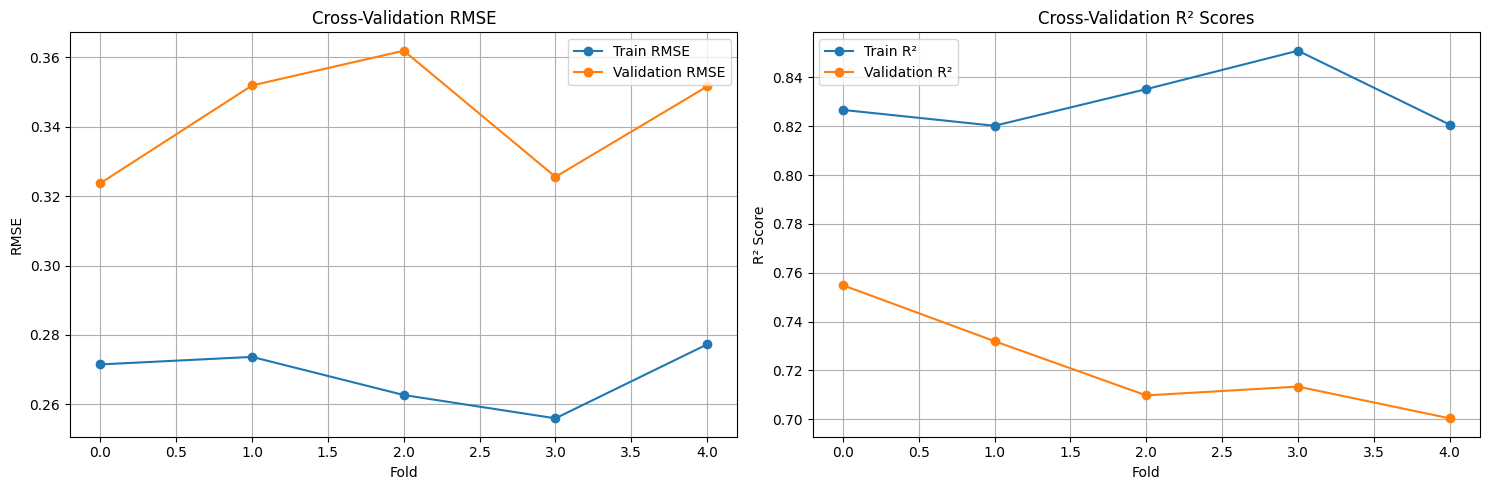


=== Cross-Validation Results ===
Average Train RMSE: 0.2682 (±0.0078)
Average Validation RMSE: 0.3430 (±0.0154)
Average Train R²: 0.8307 (±0.0115)
Average Validation R²: 0.7221 (±0.0194)

Training final model with 324 rounds...

Plotting learning curves...


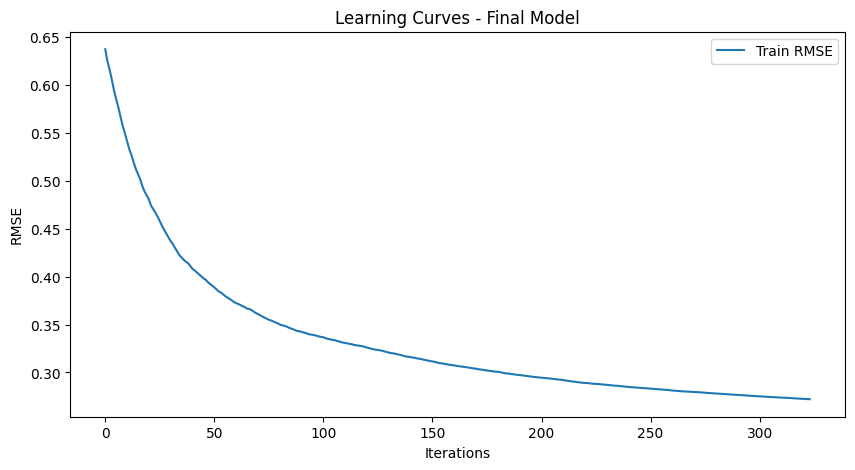


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.2658
R²: 0.8292
MAE: 0.1790

Plotting final model performance...


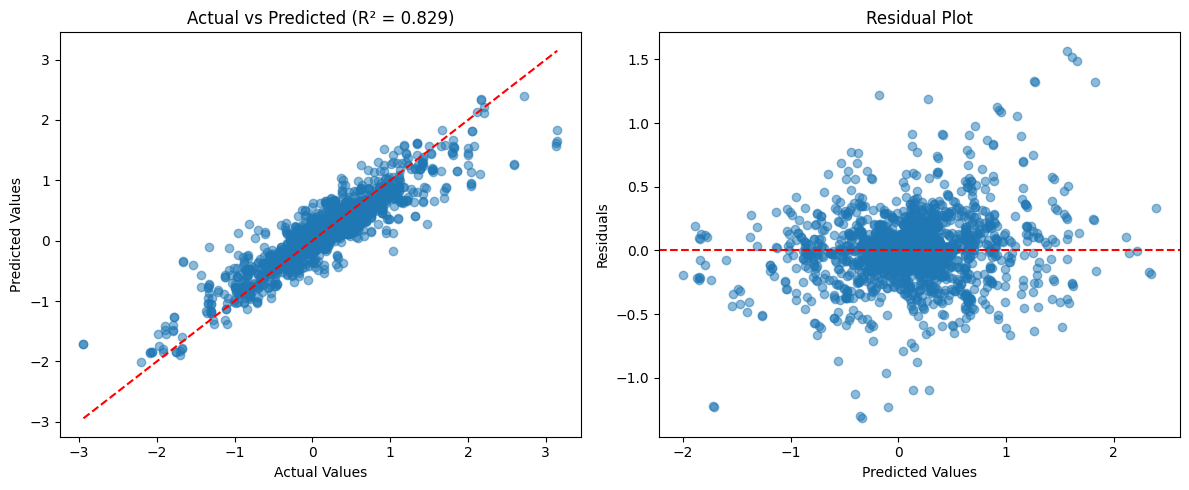


Saving results...
Done!

Plotting feature importance...


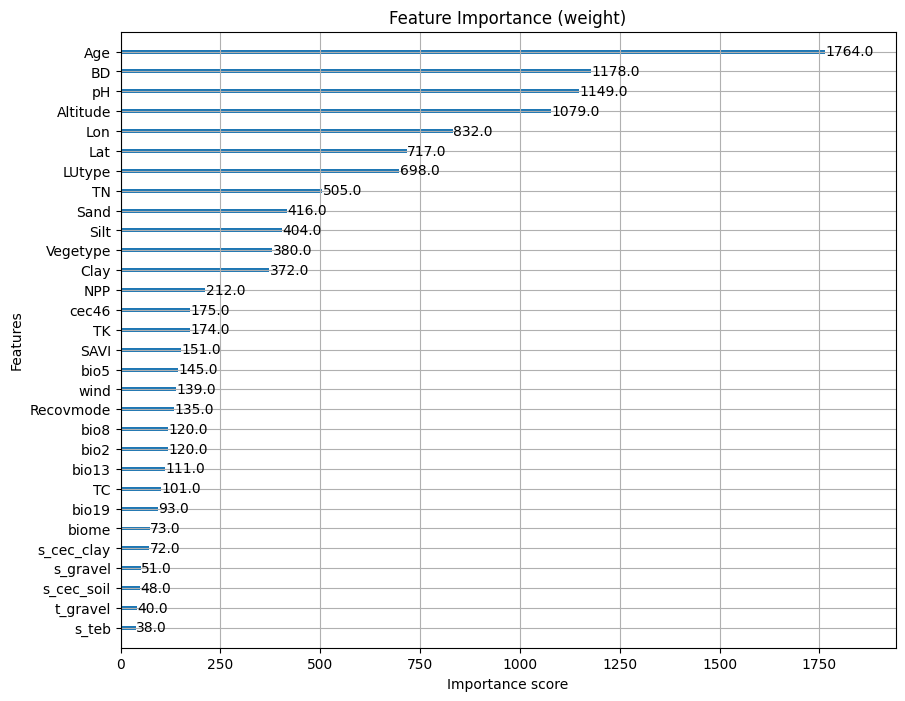

In [52]:
#all three models
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),#5,10
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():

    dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train= load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
#   dtrain_final = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
#   final_model, evals_result = tuner.train_model(best_params, dtrain_final, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")
    # 5. Feature analysis
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-05 11:43:16,166] A new study created in memory with name: no-name-97ad8f4f-f4cd-4b15-b87f-0be03b751933


4132
Starting optimized hyperparameter tuning...


[I 2025-09-05 11:43:21,153] Trial 2 finished with value: 0.5172460264224193 and parameters: {'eta': 0.025682420821696455, 'max_depth': 3, 'subsample': 0.5830194946230315, 'colsample_bytree': 0.6544610174418243, 'min_child_weight': 6, 'lambda': 12.050108917969885, 'alpha': 5.0743999595182405, 'gamma': 0.08984076940638064}. Best is trial 2 with value: 0.5172460264224193.
[I 2025-09-05 11:43:21,648] Trial 3 finished with value: 0.4794127984815722 and parameters: {'eta': 0.05477643972956151, 'max_depth': 3, 'subsample': 0.7275327700880391, 'colsample_bytree': 0.6159257325718516, 'min_child_weight': 10, 'lambda': 6.116410005738485, 'alpha': 2.8967191986622316, 'gamma': 0.2005470452462378}. Best is trial 3 with value: 0.4794127984815722.
[I 2025-09-05 11:43:21,759] Trial 4 finished with value: 0.5175672188919828 and parameters: {'eta': 0.011065778938934023, 'max_depth': 4, 'subsample': 0.7635738866168774, 'colsample_bytree': 0.5561107541646992, 'min_child_weight': 10, 'lambda': 10.7501310470


Running optimized cross-validation and saving CV models...

Saved CV models at:
- F:/model/results/cv_models\cv_model_fold_0.json
- F:/model/results/cv_models\cv_model_fold_1.json
- F:/model/results/cv_models\cv_model_fold_2.json
- F:/model/results/cv_models\cv_model_fold_3.json
- F:/model/results/cv_models\cv_model_fold_4.json

Plotting cross-validation results...


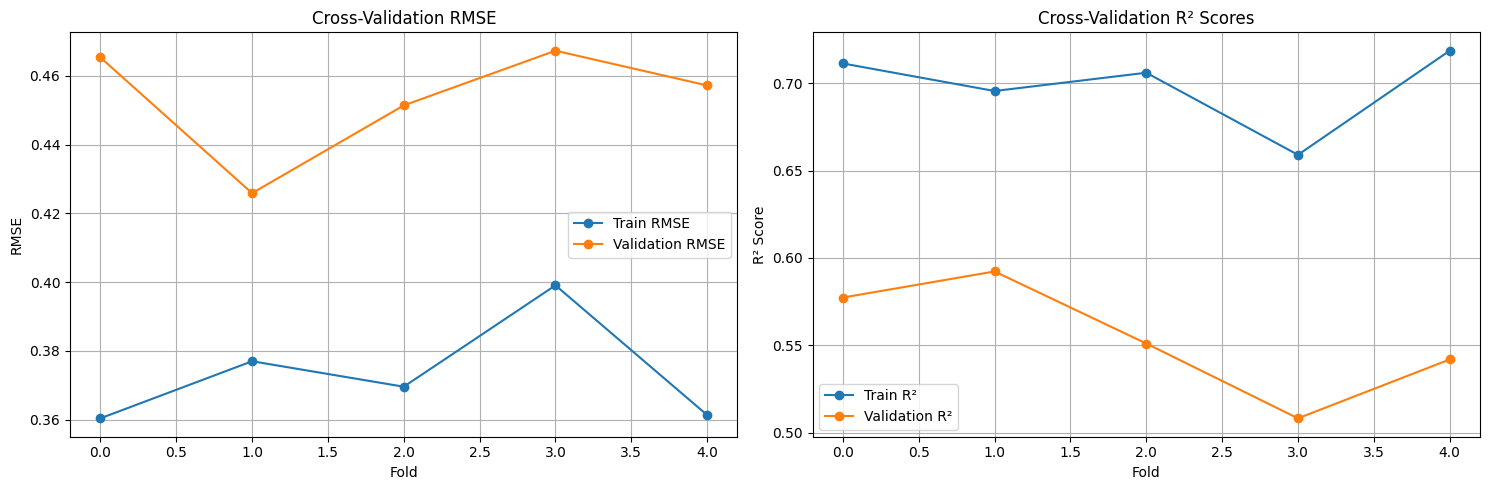


=== Cross-Validation Results ===
Average Train RMSE: 0.3735 (±0.0142)
Average Validation RMSE: 0.4535 (±0.0149)
Average Train R²: 0.6981 (±0.0209)
Average Validation R²: 0.5541 (±0.0292)

Training final model with 387 rounds...

Plotting learning curves...


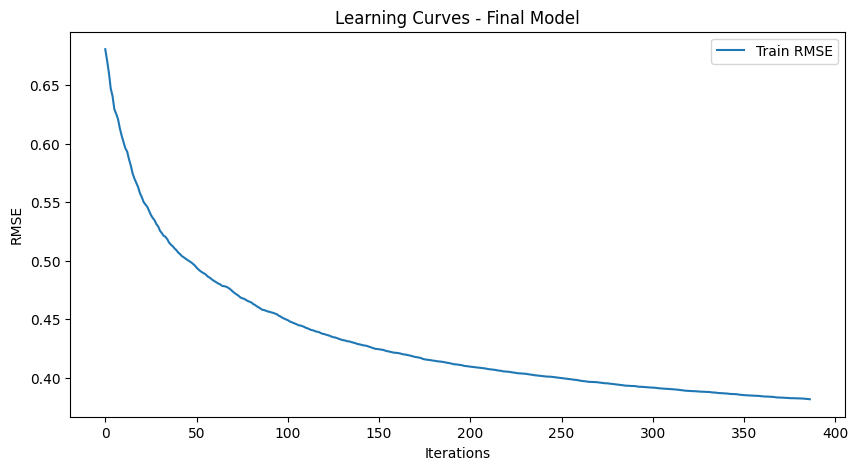


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.3853
R²: 0.7050
MAE: 0.2749

Plotting final model performance...


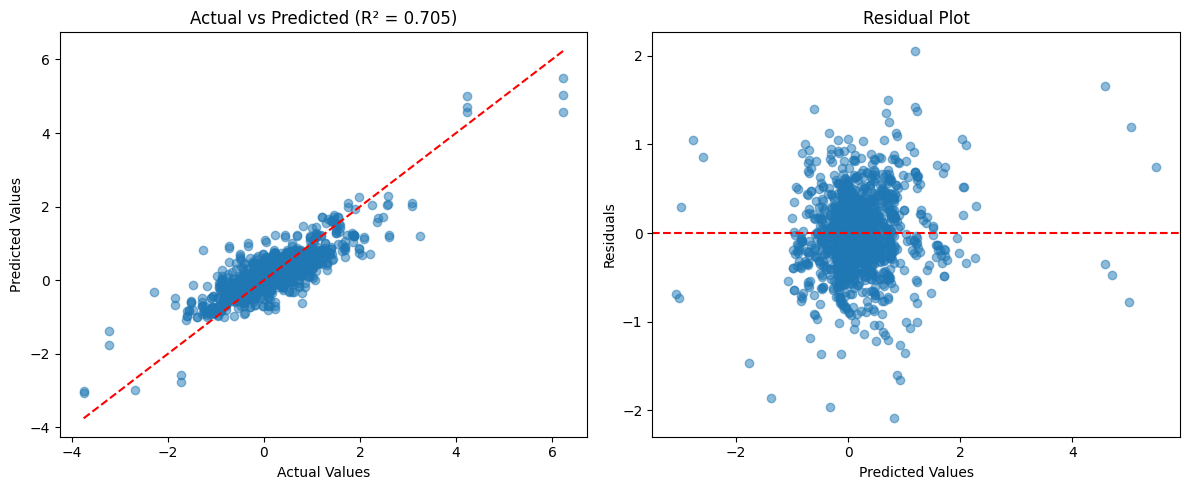


Saving results...
Done!

Plotting feature importance...


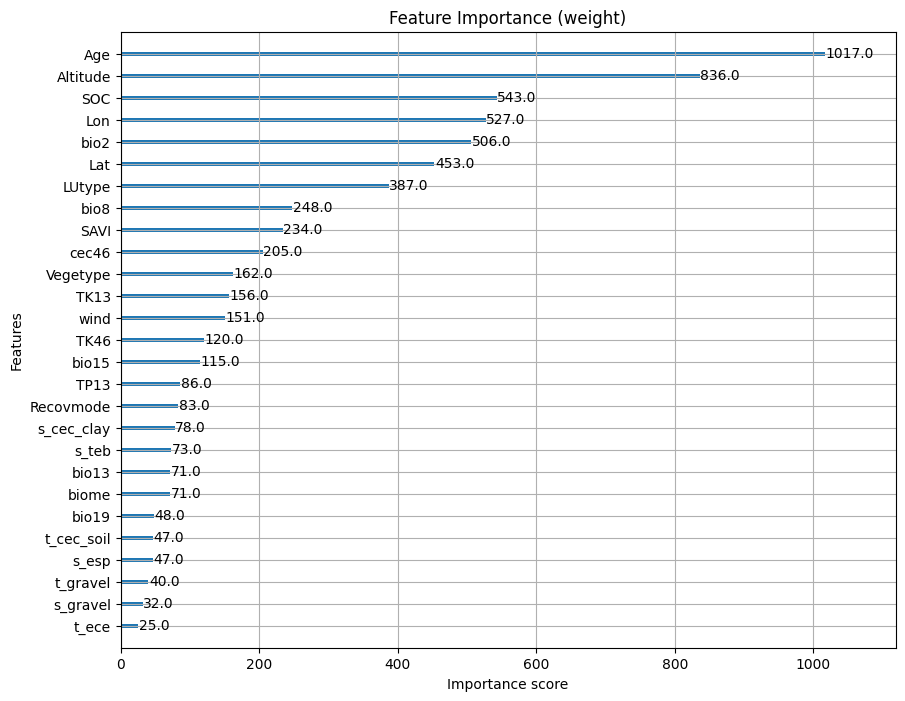

In [56]:
######LI modeling##################
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
            'lambda': trial.suggest_float('lambda', 5, 20.0),#5,10
            'alpha': trial.suggest_float('alpha', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=20,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'SOC', 'bio2']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'SOC', 'bio2',
            'Lon_log', 'Lat_log', 'Age_log', 'SOC_log', 'bio2_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():

    dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train= load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
  #  dtrain_final = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
  #  final_model, evals_result = tuner.train_model(best_params, dtrain_final, num_boost_round=optimal_rounds)


    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")
    # 5. Feature analysis
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-05 14:51:49,040] A new study created in memory with name: no-name-ff158797-5e97-460c-af35-585af1c6b78e


3054
Starting optimized hyperparameter tuning...


[I 2025-09-05 14:51:51,045] Trial 2 finished with value: 0.2505185708371297 and parameters: {'eta': 0.1732055278130842, 'max_depth': 6, 'subsample': 0.6674576374876928, 'colsample_bytree': 0.8756673432921627, 'min_child_weight': 5, 'lambda': 5.620246840604228, 'alpha': 0.5826137190299792, 'gamma': 0.18457459100985574}. Best is trial 2 with value: 0.2505185708371297.
[I 2025-09-05 14:51:52,932] Trial 7 finished with value: 0.25947662779620295 and parameters: {'eta': 0.09339692321031604, 'max_depth': 4, 'subsample': 0.6904252563640099, 'colsample_bytree': 0.8360521584881944, 'min_child_weight': 4, 'lambda': 9.82875471801471, 'alpha': 1.3895839530675187, 'gamma': 0.1353758239595933}. Best is trial 2 with value: 0.2505185708371297.
[I 2025-09-05 14:51:53,888] Trial 3 finished with value: 0.24335954520285102 and parameters: {'eta': 0.06281229028025224, 'max_depth': 5, 'subsample': 0.7993257815072432, 'colsample_bytree': 0.8923117104337579, 'min_child_weight': 4, 'lambda': 2.001335928809792,


Running optimized cross-validation and saving CV models...

=== Final Test Metrics (unbiased) ===
RMSE: 0.2314
R²: 0.8111
MAE: 0.1491

Plotting cross-validation results...


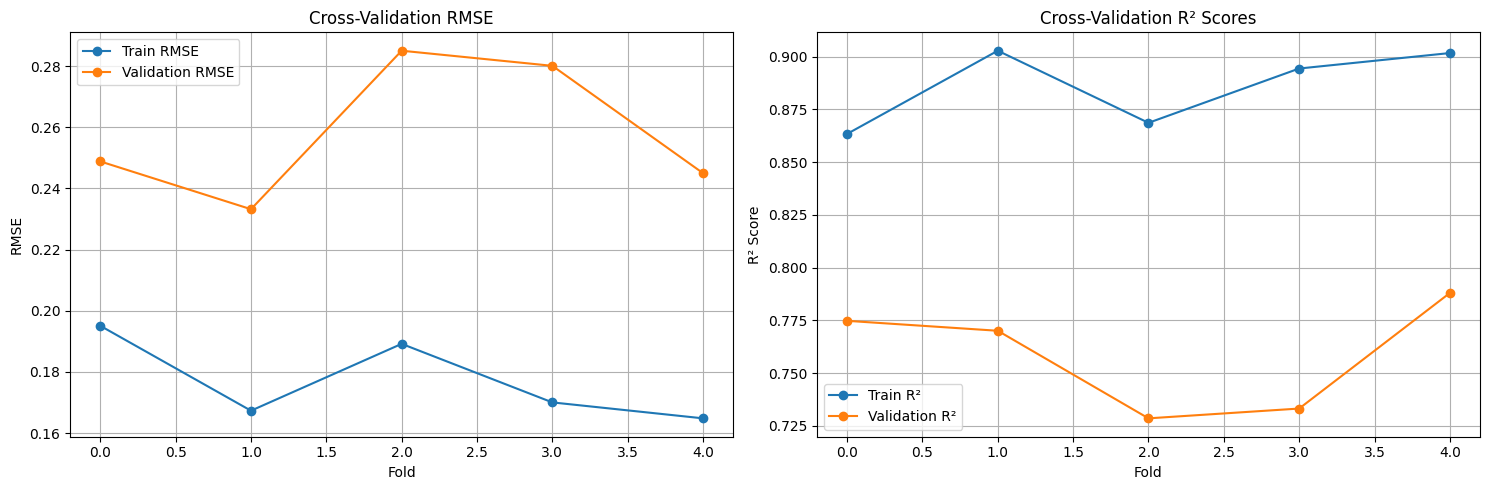


Training final mapping model with 291 rounds on ALL data...

Saving results...
Done!

Plotting feature importance...


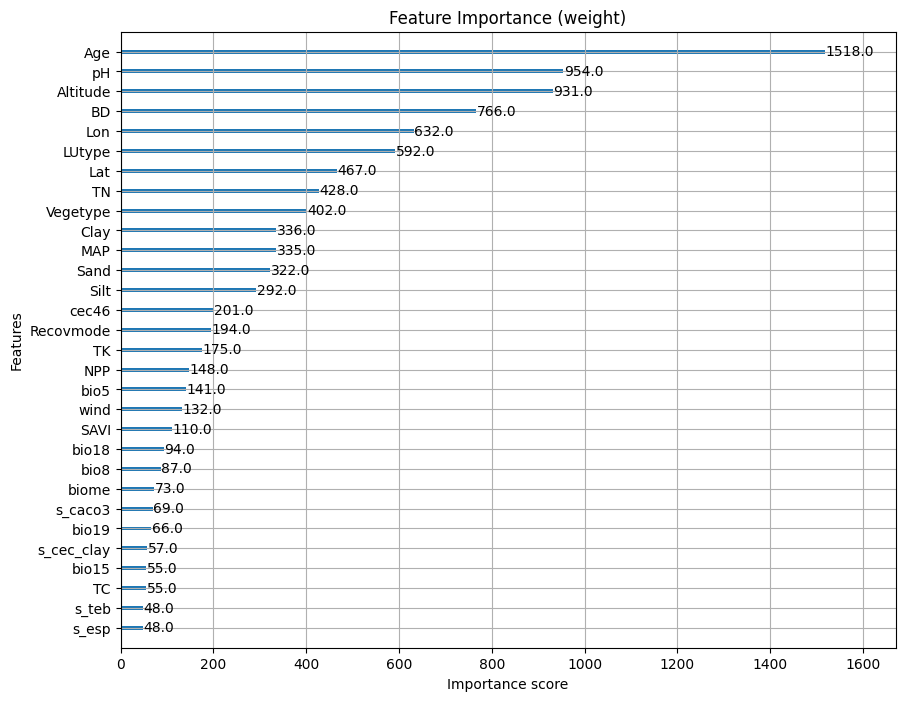

In [68]:
#Mapping models
#all three models
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),#5,10
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models'
    )

    # ✅ Unbiased test evaluation (train-only model on train set, evaluate on held-out test)
    dtrain_final = xgb.DMatrix(
        X_train, label=y_train, feature_names=X_train.columns.tolist()
    )
    temp_model, _ = tuner.train_model(
        best_params, dtrain_final,
        num_boost_round=int(np.mean(cv_results['best_iterations']))
    )
    test_metrics, _ = tuner.evaluate_model(temp_model, dtest)
    print("\n=== Final Test Metrics (unbiased) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # 3. Train final model on ALL data (mapping model, no test eval here 🚨)
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final mapping model with {optimal_rounds} rounds on ALL data...")
    dtrain_all = xgb.DMatrix(
        x1, label=y1, feature_names=x1.columns.tolist()
    )
    final_model, evals_result = tuner.train_model(
        best_params, dtrain_all,
        num_boost_round=optimal_rounds
    )

    # 🚫 不再做 dtest 评估（避免数据泄漏）
    # ✅ 保存 + 特征重要性 + SHAP
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")

    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)

    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)  # 用 X_test 只是展示 shap，可保留

if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-05 15:06:30,900] A new study created in memory with name: no-name-9ed8056d-7be8-4f0c-8896-606eb5febfa6


7772
Starting optimized hyperparameter tuning...


[I 2025-09-05 15:06:36,769] Trial 6 finished with value: 0.6191476352342101 and parameters: {'eta': 0.01755472989437671, 'max_depth': 3, 'subsample': 0.6855210670577458, 'colsample_bytree': 0.6191325846798627, 'min_child_weight': 12, 'lambda': 15.693607741141378, 'alpha': 4.280335714237964, 'gamma': 0.17353376971960652}. Best is trial 6 with value: 0.6191476352342101.
[I 2025-09-05 15:06:37,656] Trial 3 finished with value: 0.5389749593085593 and parameters: {'eta': 0.03824953013534091, 'max_depth': 4, 'subsample': 0.6637719052833407, 'colsample_bytree': 0.5447662485092327, 'min_child_weight': 9, 'lambda': 13.555377465163671, 'alpha': 3.1901565334639956, 'gamma': 0.013454009135339262}. Best is trial 3 with value: 0.5389749593085593.
[I 2025-09-05 15:06:37,675] Trial 8 finished with value: 0.6316394603754852 and parameters: {'eta': 0.014208416965077134, 'max_depth': 3, 'subsample': 0.7385853592454712, 'colsample_bytree': 0.5352721791030474, 'min_child_weight': 11, 'lambda': 17.551746789


Running optimized cross-validation and saving CV models...

=== Final Test Metrics (unbiased) ===
RMSE: 0.5024
R²: 0.5468
MAE: 0.3375

Plotting cross-validation results...


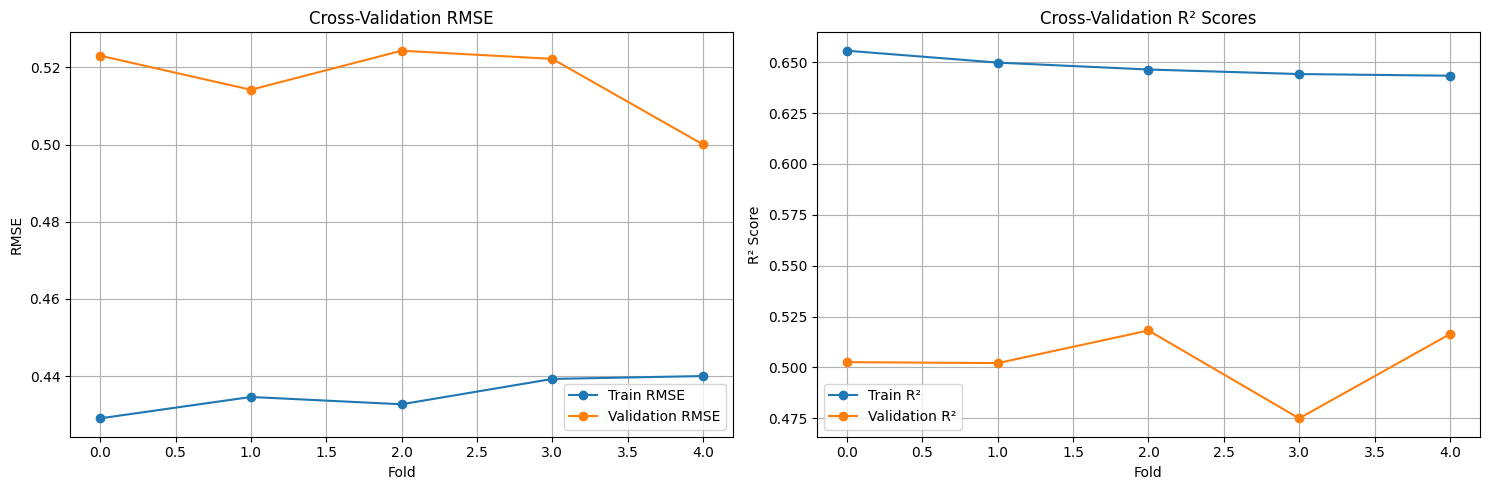


Training final mapping model with 479 rounds on ALL data...

Saving results...
Done!

Plotting feature importance...


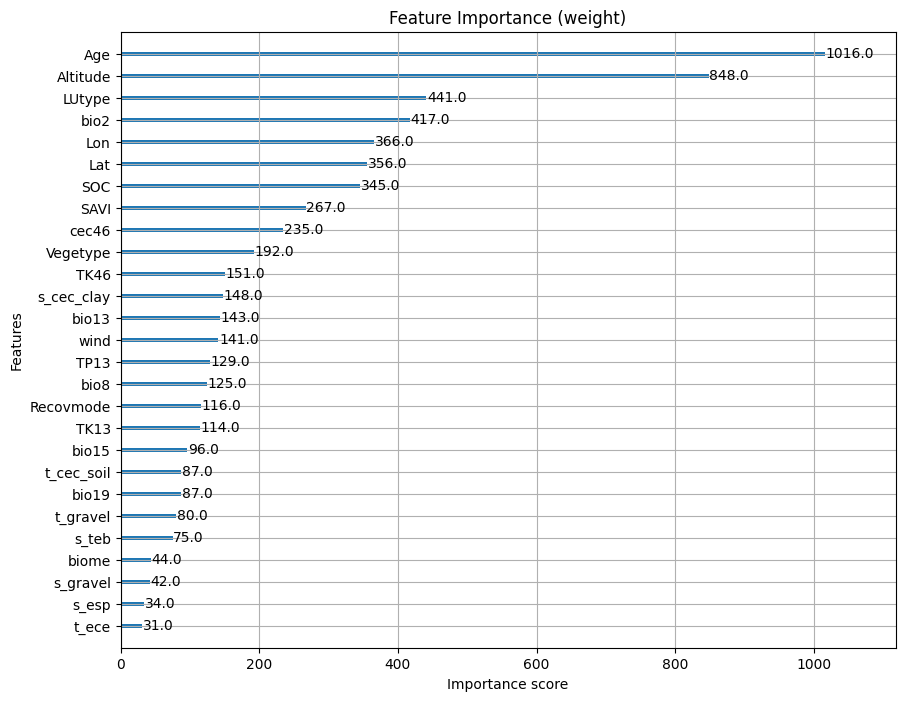

In [76]:
#Mapping LI model
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
            'lambda': trial.suggest_float('lambda', 5, 20.0),
            'alpha': trial.suggest_float('alpha', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=20,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax, max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

# These functions should be OUTSIDE the class
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented

def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'SOC', 'bio2']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)
    
    target_layer = "subsoil"#######################################################################change layer here
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'SOC', 'bio2',
            'Lon_log', 'Lat_log', 'Age_log', 'SOC_log', 'bio2_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train

def main():
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models'
    )

    # ✅ Unbiased test evaluation
    dtrain_final = xgb.DMatrix(
        X_train, label=y_train, feature_names=X_train.columns.tolist()
    )
    temp_model, _ = tuner.train_model(
        best_params, dtrain_final,
        num_boost_round=int(np.mean(cv_results['best_iterations']))
    )
    test_metrics, _ = tuner.evaluate_model(temp_model, dtest)
    print("\n=== Final Test Metrics (unbiased) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # 3. Train final model on ALL data
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final mapping model with {optimal_rounds} rounds on ALL data...")
    dtrain_all = xgb.DMatrix(
        x1, label=y1, feature_names=x1.columns.tolist()
    )
    final_model, evals_result = tuner.train_model(
        best_params, dtrain_all,
        num_boost_round=optimal_rounds
    )

    # Save results
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")

    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)

    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)

if __name__ == "__main__":
    main()

In [35]:

import xgboost as xgb
import pandas as pd

# Configuration
model_path = 'F:/model/results/xgb_model.json'##########replace wiht your directions
features_path = 'F:/model/Mapping_select_features.csv'

# 1. Load model and original features
xgb_model = xgb.Booster()
xgb_model.load_model(model_path)
original_features = xgb_model.feature_names
print("Original model features:", original_features)

# 2. Load your feature mapping CSV
select_features = pd.read_csv(features_path)
feature_columns = select_features.iloc[:, 0].dropna().tolist()
print("\nFeatures from CSV:", feature_columns)

# 3. Create feature name mapping (adjust as needed)
feature_mapping = {
    'LUtype': 'Landuse_type',
    'Recovmode': 'Recovery_mode',
    'BD': 't_bd',
    'pH': 't_ph',
    'Sand': 't_sand',
    'Silt': 't_silt',
    'Clay': 't_clay',
    'Vegetype': 'Vege_type',
    'TC': 't_oc',
    'TN': 'TN13',
    'TK': 'TK13'
}

# 4. Map original features to new names
updated_features = [
    feature_mapping.get(feat, feat)  # Use mapped name if exists, else original
    for feat in original_features
]

# 5. Validate feature availability
available_features = set(feature_columns)
required_features = set(updated_features)

missing_features = required_features - available_features
if missing_features:
    print("\nWARNING: Missing features:")
    for feat in sorted(missing_features):
        print(f"- {feat}")
    
    # Option 1: Fill with defaults (modify as needed)
    # for feat in missing_features:
    #     feature_columns.append(feat)  # Add missing features
    
    # Option 2: Raise error
    raise ValueError(f"{len(missing_features)} required features missing in CSV")

# 6. Update model with new feature names
xgb_model.feature_names = updated_features
print("\nSuccessfully updated model features:", xgb_model.feature_names)

# 7. Ensure prediction data uses these exact features
# prediction_data = input_data[updated_features]  # Must use this order

Original model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'Sand', 'Silt', 'Clay', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']

Features from CSV: ['Lon', 'Lat', 'Landuse_type', 'biome', 'Age', 'Recovery_mode', 'Altitude', 't_bd', 't_ph', 't_sand', 't_silt', 't_clay', 'Vege_type', 't_oc', 'TN13', 'TK13', 'NPP', 'cec46', 'bio2', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']

- MAP
- s_caco3


ValueError: 2 required features missing in CSV

In [ ]:
import glob
import numpy as np
Features=np.sort(glob.glob('F:/model/New_NC/*.nc'))

target_var = "yi"
seed=42

# 将循环体封装成函数
def process_nc(nc_path,Select_features,target_layer,target_carbon):
    try:
        ds_0 = xr.open_dataset(nc_path)
        ds = ds_0.to_dataframe().reset_index(drop=False).rename(columns={'x':'Lon','y':'Lat'})
        ds_0.close()
        ds = ds.rename(columns={
            'x':'Lon',
            'y':'Lat',
            'ForestAge_TC000':'Age',
            'elevation':'Altitude'
        })
        
        Original_xy=ds[['Lon','Lat']].copy()
        """
        if target_carbon=="slow":
            Xpre_name=Select_features[3]
            ds[Xpre_name]=ds[Xpre_name.replace(target_carbon,"active")]+ds[Xpre_name.replace(target_carbon,"passive")]
        """
        ds = ds[Select_features]  # 确保Select_feature_now在作用域内
        ds=ds.dropna()
        xgb_model.feature_names=None  #危险代码 需自行确保模型与输入特征真的顺序一致,这里只是改名
        #ds = ds.loc[~ds['Landuse_type'].isna()]
        #ds = ds.loc[~ds['Age'].isna()]
        if ds.shape[0] == 0:
            Original_xy['Predicted']=np.nan
            return Original_xy
        ds = ds.reset_index(drop=True)
        
        #ds.columns = data_predictor_VIF.T.values[0]  # 确保data_predictor_VIF在作用域内
        
        # 确保xgb_model在作用域内
        #predict_now = xgb_model.predict(xgb.DMatrix(ds[data_predictor_VIF.T.values[0]]))
        predict_now = xgb_model.predict(xgb.DMatrix(ds.values)) #按照训练模型时的用法改编

        results = pd.concat([
            ds[['Lon','Lat']],
            pd.Series(predict_now, name='Predicted'),
        ], axis=1)

        #resume the original x,y and fill missing values with np.nan
        Original_xy['Predicted']=np.nan
        Original_xy=Original_xy.set_index(['Lon','Lat'])
        results=results.set_index(['Lon','Lat'])
        results=results.reindex(Original_xy.index).reset_index(drop=False)
        
        del Original_xy,ds
    except Exception as e:
        print(f"Error processing {nc_path}: {e}")
        raise e
    

    return results
Select_features=pd.read_csv('F:/model/Mapping_select_features.csv',index_col=None,sep=',').T.reset_index(drop=True)

xgb_model=xgb.Booster()
xgb_model.load_model(f'F:/model/results/xgb_model.json')
target_carbon = "passive"
target_layer = "topsoil"                                                                    
All_results = Parallel(n_jobs=17 ,verbose=10)(  # n_jobs=-1表示使用所有CPU核心
    delayed(process_nc)(nc_path,Select_features.values[0],target_layer,target_carbon) for nc_path in Features
)

# 合并结果（与原代码保持一致）
All_results = pd.concat(All_results, axis=0).reset_index(drop=True)
All_results=All_results.rename(columns={'Lon':'x','Lat':'y','Predicted':f'{target_carbon}_{target_layer}'}).set_index(['x','y']).to_xarray().rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs("EPSG:4326").transpose('y', 'x')[f'{target_carbon}_{target_layer}']

All_results.rio.to_raster(f'F:/model/Mapping_{target_carbon}_{target_layer}_newCLIMATE.tif',nodata=np.nan ,compress='LZW')

print(f"Mapping for {target_carbon} carbon in {target_layer} layer is done")

[Parallel(n_jobs=17)]: Using backend LokyBackend with 17 concurrent workers.


ValueError: No objects to concatenate

In [ ]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
from joblib import Parallel, delayed
import rioxarray

# Initialize and set up
Features = np.sort(glob.glob('E:/Mapping_INPUT/*.nc'))
target_var = "yi"
seed = 42

# Load model and features
Select_features = pd.read_csv('F:/model/Mapping_select_features.csv', index_col=None, sep=',').T.reset_index(drop=True)
xgb_model = xgb.Booster()
xgb_model.load_model(f'F:/model/results/xgb_model.json')
target_carbon = "passive"
target_layer = "topsoil"

# 将循环体封装成函数
def process_nc(nc_path, Select_features, target_layer, target_carbon):
    try:
        print(f"Processing: {nc_path}")
        
        # Open the dataset
        ds_0 = xr.open_dataset(nc_path)
        
        # Check if the file has any data
        if len(ds_0.data_vars) == 0:
            print(f"Warning: No data variables in {nc_path}")
            ds_0.close()
            return None
        
        # Convert to dataframe and rename columns
        ds = ds_0.to_dataframe().reset_index(drop=False).rename(columns={'x': 'Lon', 'y': 'Lat'})
        ds_0.close()
        
        # Rename specific columns
        ds = ds.rename(columns={
            'x': 'Lon',
            'y': 'Lat',
            'ForestAge_TC000': 'Age',
            'elevation': 'Altitude'
        })
        
        # Store original coordinates
        Original_xy = ds[['Lon', 'Lat']].copy()
        
        # Check if all required features exist
        missing_features = [feat for feat in Select_features if feat not in ds.columns]
        if missing_features:
            print(f"Warning: Missing features in {nc_path}: {missing_features}")
            return None
        
        # Select features and drop NA
        ds = ds[Select_features]
        ds = ds.dropna()
        
        # Check if any data remains after dropping NA
        if ds.shape[0] == 0:
            print(f"Warning: No valid data after dropping NA in {nc_path}")
            Original_xy['Predicted'] = np.nan
            return Original_xy[['Lon', 'Lat', 'Predicted']]
        
        # Reset index and predict
        ds = ds.reset_index(drop=True)
        xgb_model.feature_names = None  # Ensure feature order matches training
        
        try:
            predict_now = xgb_model.predict(xgb.DMatrix(ds.values))
        except Exception as e:
            print(f"Prediction error in {nc_path}: {e}")
            return None
        
        # Create results dataframe
        results = pd.concat([
            ds[['Lon', 'Lat']],
            pd.Series(predict_now, name='Predicted'),
        ], axis=1)
        
        # Reindex to original coordinates and fill missing values
        Original_xy['Predicted'] = np.nan
        Original_xy = Original_xy.set_index(['Lon', 'Lat'])
        results = results.set_index(['Lon', 'Lat'])
        
        # Use merge instead of reindex for better handling
        merged_results = Original_xy.reset_index().merge(
            results.reset_index(), 
            on=['Lon', 'Lat'], 
            how='left', 
            suffixes=('', '_pred')
        )
        
        # Clean up column names
        if 'Predicted_pred' in merged_results.columns:
            merged_results['Predicted'] = merged_results['Predicted_pred']
            merged_results = merged_results[['Lon', 'Lat', 'Predicted']]
        else:
            merged_results['Predicted'] = np.nan
            merged_results = merged_results[['Lon', 'Lat', 'Predicted']]
        
        return merged_results
        
    except Exception as e:
        print(f"Error processing {nc_path}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Process files in parallel with better error handling
print(f"Processing {len(Features)} files...")
All_results_list = Parallel(n_jobs=17, verbose=10)(
    delayed(process_nc)(nc_path, Select_features.values[0], target_layer, target_carbon) 
    for nc_path in Features
)

# Filter out None results
valid_results = [result for result in All_results_list if result is not None]

if len(valid_results) == 0:
    print("Error: No valid results were generated from any file!")
    print("Possible reasons:")
    print("1. Files are empty or corrupted")
    print("2. Required features are missing from the NetCDF files")
    print("3. All data was filtered out due to NA values")
    
    # Debug: Check first file
    if len(Features) > 0:
        print(f"\nDebugging first file: {Features[0]}")
        ds_test = xr.open_dataset(Features[0])
        print(f"Variables in first file: {list(ds_test.data_vars.keys())}")
        print(f"Dimensions: {dict(ds_test.dims)}")
        ds_test.close()
    
    exit(1)

# 合并结果
try:
    All_results = pd.concat(valid_results, axis=0).reset_index(drop=True)
    print(f"Successfully merged {len(valid_results)} results")
    
    # Continue with raster export
    All_results = All_results.rename(columns={
        'Lon': 'x', 
        'Lat': 'y', 
        'Predicted': f'{target_carbon}_{target_layer}'
    }).set_index(['x', 'y']).to_xarray()
    
    All_results = All_results.rio.set_spatial_dims(x_dim="x", y_dim="y")
    All_results = All_results.rio.write_crs("EPSG:4326")
    All_results = All_results.transpose('y', 'x')[f'{target_carbon}_{target_layer}']
    
    # Export to raster
    output_path = f'F:/model/Mapping_{target_carbon}_{target_layer}_newCLIMATE.tif'
    All_results.rio.to_raster(output_path, nodata=np.nan, compress='LZW')
    
    print(f"Mapping for {target_carbon} carbon in {target_layer} layer is done")
    print(f"Output saved to: {output_path}")
    
except Exception as e:
    print(f"Error during result merging: {e}")
    import traceback
    traceback.print_exc()

Processing 324 files...


[Parallel(n_jobs=17)]: Using backend LokyBackend with 17 concurrent workers.
[Parallel(n_jobs=17)]: Done   7 tasks      | elapsed:  1.8min
[Parallel(n_jobs=17)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=17)]: Done  27 tasks      | elapsed:  3.6min
[Parallel(n_jobs=17)]: Done  38 tasks      | elapsed:  5.4min
[Parallel(n_jobs=17)]: Done  51 tasks      | elapsed:  5.9min
[Parallel(n_jobs=17)]: Done  64 tasks      | elapsed:  7.6min
[Parallel(n_jobs=17)]: Done  79 tasks      | elapsed:  9.5min
[Parallel(n_jobs=17)]: Done  94 tasks      | elapsed: 11.4min
[Parallel(n_jobs=17)]: Done 111 tasks      | elapsed: 13.3min
[Parallel(n_jobs=17)]: Done 128 tasks      | elapsed: 15.2min
[Parallel(n_jobs=17)]: Done 147 tasks      | elapsed: 17.1min
[Parallel(n_jobs=17)]: Done 166 tasks      | elapsed: 19.0min
[Parallel(n_jobs=17)]: Done 187 tasks      | elapsed: 21.0min
[Parallel(n_jobs=17)]: Done 208 tasks      | elapsed: 23.6min
[Parallel(n_jobs=17)]: Done 231 tasks      | elapsed: 2

Successfully merged 324 results
Mapping for passive carbon in topsoil layer is done
Output saved to: F:/model/Mapping_passive_topsoil_newCLIMATE.tif


Checking directory: E:/Mapping_INPUT/
Directory exists: True
Files in directory: ['-100_-10.nc', '-100_0.nc', '-100_10.nc', '-100_20.nc', '-100_30.nc', '-100_40.nc', '-100_50.nc', '-100_60.nc', '-100_70.nc', '-100_80.nc']
Found 324 NetCDF files
Loading features from: F:/model/Mapping_select_features.csv
Selected features: ['Lon' 'Lat' 'Landuse_type' 'biome' 'Age' 'Recovery_mode' 'Altitude'
 't_bd' 't_ph' 't_sand' 't_silt' 't_clay' 'Vege_type' 'Purpose' 't_oc'
 'TN13' 'TK13' 'NPP' 'cec46' 'bio2' 'bio5' 'bio8' 'bio13' 'bio19' 'wind'
 'SAVI' 's_cec_clay' 's_cec_soil' 's_ece' 's_esp' 's_gravel' 's_teb'
 't_ece' 't_gravel']
Loading model from: F:/model/results/xgb_model.json
Model loaded successfully

Testing first file structure: E:/Mapping_INPUT\-100_-10.nc
Variables: ['AI', 'ForestAge_TC000', 'Landuse_type', 'MAP', 'MAT', 'NPP', 'ORCHIDEE-MICT_subsoil_active', 'ORCHIDEE-MICT_subsoil_passive', 'ORCHIDEE-MICT_subsoil_slow', 'ORCHIDEE-MICT_topsoil_active', 'ORCHIDEE-MICT_topsoil_passive', '

C:\Users\pc\AppData\Local\Temp\ipykernel_20692\162211499.py:82: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(test_ds.dims)}")
[Parallel(n_jobs=17)]: Using backend LokyBackend with 17 concurrent workers.
[Parallel(n_jobs=17)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=17)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=17)]: Done  27 tasks      | elapsed:  3.6min
[Parallel(n_jobs=17)]: Done  38 tasks      | elapsed:  4.6min
[Parallel(n_jobs=17)]: Done  51 tasks      | elapsed:  5.6min
[Parallel(n_jobs=17)]: Done  64 tasks      | elapsed:  7.1min
[Parallel(n_jobs=17)]: Done  79 tasks      | elapsed:  8.7min
[Parallel(n_jobs=17)]: Done  94 tasks      | elapsed: 10.3min
[Parallel(n_jobs=17)]: Done 111 tasks      | elapsed: 11.8min
[Parallel(

Successfully merged 324 results
Total points: 466560000
Mapping for passive carbon in topsoil layer is done
Output saved to: F:/model/Mapping_passive_topsoil_newCLIMATE.tif
Error during processing: Unable to allocate 742. MiB for an array with shape (18000, 43200) and data type bool


Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_20692\162211499.py", line 294, in <module>
    plot_results(grid_data, plot_path)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_20692\162211499.py", line 274, in plot_results
    im = data_array.plot(
        cmap='viridis',
    ...<3 lines>...
        vmax=vmax
    )
  File "E:\workspace\venv\Lib\site-packages\xarray\plot\accessor.py", line 48, in __call__
    return dataarray_plot.plot(self._da, **kwargs)
           ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "E:\workspace\venv\Lib\site-packages\xarray\plot\dataarray_plot.py", line 316, in plot
    return plotfunc(darray, **kwargs)
  File "E:\workspace\venv\Lib\site-packages\xarray\plot\dataarray_plot.py", line 1612, in newplotfunc
    primitive = plotfunc(
        xplt,
    ...<7 lines>...
        **kwargs,
    )
  File "E:\workspace\venv\Lib\site-packages\xarray\plot\dataarray_plot.py", line 2321, in pcol

Processing completed!


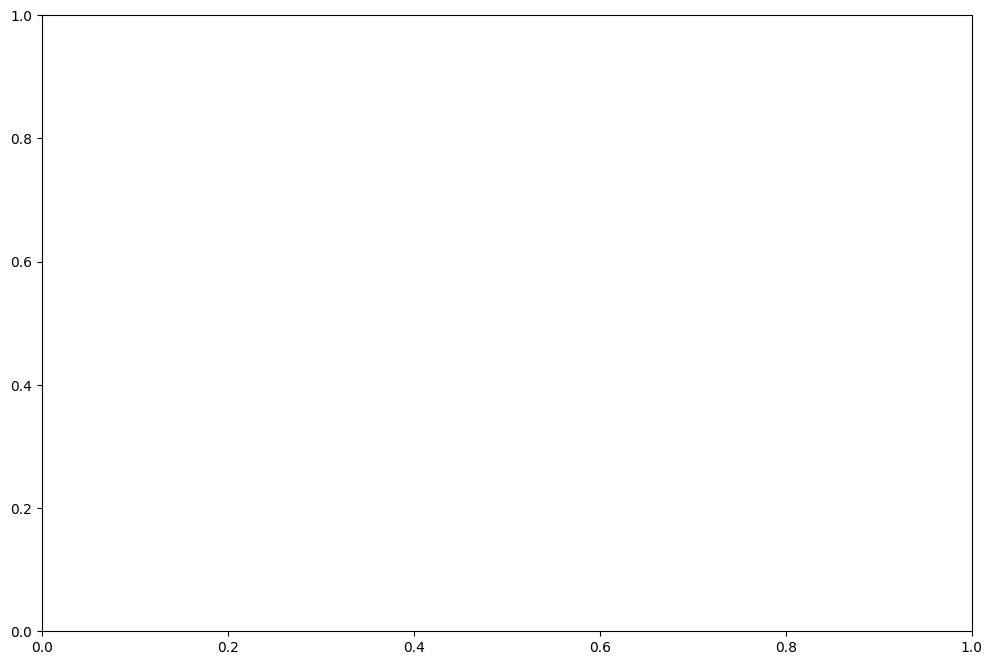

In [ ]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
from joblib import Parallel, delayed
import rioxarray
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from scipy.interpolate import griddata
import os

# Initialize and set up
nc_directory = 'E:/Mapping_INPUT/'
print(f"Checking directory: {nc_directory}")
print(f"Directory exists: {os.path.exists(nc_directory)}")

if os.path.exists(nc_directory):
    print(f"Files in directory: {os.listdir(nc_directory)[:10]}")  # 显示前10个文件
else:
    print("Directory does not exist!")
    exit(1)

Features = np.sort(glob.glob('E:/Mapping_INPUT/*.nc'))
print(f"Found {len(Features)} NetCDF files")

if len(Features) == 0:
    print("No NetCDF files found! Trying alternative patterns...")
    # 尝试其他可能的文件模式
    alternative_patterns = [
        'E:/Mapping_INPUT/*.nc4',
        'E:/Mapping_INPUT/*.netcdf',
        'E:/Mapping_INPUT/*.nc.*'
    ]
    for pattern in alternative_patterns:
        files = glob.glob(pattern)
        if files:
            Features = np.sort(files)
            print(f"Found files with pattern {pattern}: {len(Features)} files")
            break

if len(Features) == 0:
    print("No files found. Exiting.")
    exit(1)

target_var = "yi"
seed = 42

# Load model and features
Select_features_path = 'F:/model/Mapping_select_features.csv'
print(f"Loading features from: {Select_features_path}")

if os.path.exists(Select_features_path):
    Select_features = pd.read_csv(Select_features_path, index_col=None, sep=',').T.reset_index(drop=True)
    feature_list = Select_features.values[0]
    print(f"Selected features: {feature_list}")
else:
    print("Features file not found!")
    exit(1)

# Load model
model_path = 'F:/model/results/xgb_model.json'
print(f"Loading model from: {model_path}")

if os.path.exists(model_path):
    xgb_model = xgb.Booster()
    xgb_model.load_model(model_path)
    print("Model loaded successfully")
else:
    print("Model file not found!")
    exit(1)

target_carbon = "passive"
target_layer = "topsoil"

# 测试第一个文件的结构
if len(Features) > 0:
    print(f"\nTesting first file structure: {Features[0]}")
    try:
        test_ds = xr.open_dataset(Features[0])
        print(f"Variables: {list(test_ds.data_vars.keys())}")
        print(f"Dimensions: {dict(test_ds.dims)}")
        print(f"Coordinates: {list(test_ds.coords.keys())}")
        test_ds.close()
    except Exception as e:
        print(f"Error opening test file: {e}")

# 改进的处理函数，包含边界处理
def process_nc(nc_path, Select_features, target_layer, target_carbon):
    try:
        print(f"Processing: {os.path.basename(nc_path)}")
        
        # Open the dataset
        ds_0 = xr.open_dataset(nc_path)
        
        # Check if the file has any data
        if len(ds_0.data_vars) == 0:
            print(f"Warning: No data variables in {nc_path}")
            ds_0.close()
            return None
        
        # Convert to dataframe
        ds = ds_0.to_dataframe().reset_index(drop=False)
        ds_0.close()
        
        # 动态重命名列
        rename_dict = {}
        column_mapping = {
            'x': 'Lon',
            'y': 'Lat',
            'longitude': 'Lon',
            'latitude': 'Lat',
            'ForestAge_TC000': 'Age',
            'elevation': 'Altitude'
        }
        
        for old_name, new_name in column_mapping.items():
            if old_name in ds.columns:
                rename_dict[old_name] = new_name
        
        ds = ds.rename(columns=rename_dict)
        
        # 确保有Lon和Lat列
        if 'Lon' not in ds.columns or 'Lat' not in ds.columns:
            print(f"Warning: Lon/Lat columns not found. Available columns: {ds.columns.tolist()}")
            return None
        
        # Store original coordinates
        Original_xy = ds[['Lon', 'Lat']].copy()
        
        # Check if all required features exist
        missing_features = [feat for feat in Select_features if feat not in ds.columns]
        if missing_features:
            print(f"Warning: Missing features: {missing_features}")
            available_features = [col for col in ds.columns if col in Select_features]
            print(f"Available features: {available_features}")
            return None
        
        # Select features and drop NA
        ds = ds[Select_features]
        ds = ds.dropna()
        
        # Check if any data remains after dropping NA
        if ds.shape[0] == 0:
            print(f"Warning: No valid data after dropping NA")
            Original_xy['Predicted'] = np.nan
            return Original_xy[['Lon', 'Lat', 'Predicted']]
        
        # Reset index and predict
        ds = ds.reset_index(drop=True)
        xgb_model.feature_names = None
        
        try:
            predict_now = xgb_model.predict(xgb.DMatrix(ds.values))
        except Exception as e:
            print(f"Prediction error: {e}")
            return None
        
        # Create results dataframe
        results = pd.concat([
            ds[['Lon', 'Lat']],
            pd.Series(predict_now, name='Predicted'),
        ], axis=1)
        
        # 使用网格插值而不是简单的重索引，避免边界问题
        def interpolate_to_grid(original_coords, result_points):
            """将点数据插值到原始网格"""
            # 获取原始网格坐标
            original_points = original_coords[['Lon', 'Lat']].values
            
            # 获取结果点的坐标和值
            result_coords = result_points[['Lon', 'Lat']].values
            result_values = result_points['Predicted'].values
            
            # 使用最近邻插值
            interpolated_values = griddata(
                result_coords, 
                result_values, 
                original_points, 
                method='nearest', 
                fill_value=np.nan
            )
            
            original_coords['Predicted'] = interpolated_values
            return original_coords
        
        # 应用插值
        final_results = interpolate_to_grid(Original_xy.copy(), results)
        
        # 应用边界平滑
        if not final_results['Predicted'].isna().all():
            # 创建网格并进行中值滤波
            try:
                grid = final_results.set_index(['Lat', 'Lon'])['Predicted'].unstack()
                grid_values = grid.values
                
                # 应用中值滤波去除边界噪声
                smoothed_values = median_filter(grid_values, size=3, mode='nearest')
                
                # 更新网格值
                grid.values = smoothed_values
                
                # 重新转换为DataFrame
                final_results = grid.stack().reset_index()
                final_results.columns = ['Lat', 'Lon', 'Predicted']
                final_results = final_results[['Lon', 'Lat', 'Predicted']]  # 重新排序列
                
            except Exception as e:
                print(f"Boundary smoothing failed: {e}, using original data")
        
        return final_results.dropna(subset=['Predicted'])
        
    except Exception as e:
        print(f"Error processing {os.path.basename(nc_path)}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Process files in parallel
print(f"\nProcessing {len(Features)} files...")
All_results_list = Parallel(n_jobs=min(17, len(Features)), verbose=10)(
    delayed(process_nc)(nc_path, feature_list, target_layer, target_carbon) 
    for nc_path in Features
)

# Filter out None results
valid_results = [result for result in All_results_list if result is not None]

if len(valid_results) == 0:
    print("Error: No valid results were generated from any file!")
    exit(1)

# 合并结果
try:
    All_results = pd.concat(valid_results, axis=0, ignore_index=True)
    print(f"Successfully merged {len(valid_results)} results")
    print(f"Total points: {len(All_results)}")
    
    # 转换为xarray并设置空间维度
    All_results = All_results.rename(columns={
        'Lon': 'x', 
        'Lat': 'y', 
        'Predicted': f'{target_carbon}_{target_layer}'
    })
    
    # 创建网格数据
    grid_data = All_results.set_index(['y', 'x']).to_xarray()[f'{target_carbon}_{target_layer}']
    
    # 设置CRS和空间维度
    grid_data = grid_data.rio.set_spatial_dims(x_dim="x", y_dim="y")
    grid_data = grid_data.rio.write_crs("EPSG:4326")
    
    # 确保正确的维度顺序
    if 'x' in grid_data.dims and 'y' in grid_data.dims:
        grid_data = grid_data.transpose('y', 'x')
    
    # 导出到栅格
    output_path = f'F:/model/Mapping_{target_carbon}_{target_layer}_newCLIMATE.tif'
    grid_data.rio.to_raster(output_path, nodata=-9999, compress='LZW')
    
    print(f"Mapping for {target_carbon} carbon in {target_layer} layer is done")
    print(f"Output saved to: {output_path}")
    
    # 绘制结果图（可选）
    def plot_results(data_array, output_image_path):
        """绘制结果地图"""
        plt.figure(figsize=(12, 8))
        
        # 计算合适的数据范围，避免极端值
        vmin = np.nanpercentile(data_array.values, 2)
        vmax = np.nanpercentile(data_array.values, 98)
        
        # 绘制地图
        im = data_array.plot(
            cmap='viridis',
            add_colorbar=True,
            cbar_kwargs={'label': f'{target_carbon} Carbon Content', 'shrink': 0.8},
            vmin=vmin,
            vmax=vmax
        )
        
        plt.title(f'{target_carbon.capitalize()} Carbon in {target_layer.capitalize()}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        
        # 保存图像
        plt.savefig(output_image_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Plot saved to: {output_image_path}")
    
    # 生成绘图
    plot_path = f'F:/model/Mapping_{target_carbon}_{target_layer}_plot.png'
    plot_results(grid_data, plot_path)
    
except Exception as e:
    print(f"Error during processing: {e}")
    import traceback
    traceback.print_exc()

print("Processing completed!")


In [ ]:
# 初始化变量
Features = np.sort(glob.glob('F:/model/New_NC/*.nc'))
target_var = "yi"
seed = 42

# 加载模型和特征
Select_features = pd.read_csv('F:/model/Mapping_select_features.csv', index_col=None, sep=',').T.reset_index(drop=True)
xgb_model = xgb.Booster()
xgb_model.load_model('F:/model/results/xgb_model.json')
target_carbon = "passive"
target_layer = "topsoil"

# 将循环体封装成函数
def process_nc(nc_path, Select_features, target_layer, target_carbon):
    try:
        # 打开数据集
        ds_0 = xr.open_dataset(nc_path)
        ds = ds_0.to_dataframe().reset_index(drop=False).rename(columns={'x': 'Lon', 'y': 'Lat'})
        ds_0.close()
        
        # 重命名列
        ds = ds.rename(columns={
            'x': 'Lon',
            'y': 'Lat',
            'ForestAge_TC000': 'Age',
            'elevation': 'Altitude'
        })
        
        # 保存原始坐标
        Original_xy = ds[['Lon', 'Lat']].copy()
        
        # 选择特征并删除缺失值
        ds = ds[Select_features]
        ds = ds.dropna()
        
        # 检查是否有有效数据
        if ds.shape[0] == 0:
            print(f"No valid data in {nc_path}")
            Original_xy['Predicted'] = np.nan
            return Original_xy
        
        # 重置索引并准备预测
        ds = ds.reset_index(drop=True)
        xgb_model.feature_names = None  # 确保模型与输入特征顺序一致
        
        # 进行预测
        predict_now = xgb_model.predict(xgb.DMatrix(ds.values))
        
        # 创建结果DataFrame
        results = pd.concat([
            ds[['Lon', 'Lat']],
            pd.Series(predict_now, name='Predicted'),
        ], axis=1)
        
        # 恢复原始坐标并用NaN填充缺失值
        Original_xy['Predicted'] = np.nan
        Original_xy = Original_xy.set_index(['Lon', 'Lat'])
        results = results.set_index(['Lon', 'Lat'])
        results = results.reindex(Original_xy.index).reset_index(drop=False)
        
        return results
        
    except Exception as e:
        print(f"Error processing {nc_path}: {str(e)}")
        # 返回一个空的DataFrame而不是None
        return pd.DataFrame(columns=['Lon', 'Lat', 'Predicted'])

# 并行处理
print(f"开始处理 {len(Features)} 个文件...")
All_results = Parallel(n_jobs=17, verbose=10)(
    delayed(process_nc)(nc_path, Select_features.values[0], target_layer, target_carbon) 
    for nc_path in Features
)

# 过滤掉空结果
All_results = [result for result in All_results if not result.empty]

# 检查是否有结果
if len(All_results) == 0:
    print("警告: 所有文件处理失败，没有有效结果!")
    # 创建一个空的最终结果
    All_results = pd.DataFrame(columns=['Lon', 'Lat', 'Predicted'])
else:
    # 合并结果
    All_results = pd.concat(All_results, axis=0).reset_index(drop=True)

# 转换为xarray并保存为GeoTIFF
if not All_results.empty:
    try:
        All_results = All_results.rename(
            columns={'Lon': 'x', 'Lat': 'y', 'Predicted': f'{target_carbon}_{target_layer}'}
        ).set_index(['x', 'y']).to_xarray()
        
        All_results = All_results.rio.set_spatial_dims(x_dim="x", y_dim="y")
        All_results = All_results.rio.write_crs("EPSG:4326")
        All_results = All_results.transpose('y', 'x')[f'{target_carbon}_{target_layer}']
        
        # 保存为GeoTIFF
        output_path = f'F:/model/Mapping_{target_carbon}_{target_layer}_newCLIMATE.tif'
        All_results.rio.to_raster(output_path, nodata=np.nan, compress='LZW')
        
        print(f"Mapping for {target_carbon} carbon in {target_layer} layer is done")
        print(f"结果已保存至: {output_path}")
        
    except Exception as e:
        print(f"保存结果时出错: {str(e)}")
else:
    print("没有有效数据可保存")

开始处理 0 个文件...
警告: 所有文件处理失败，没有有效结果!
没有有效数据可保存


[Parallel(n_jobs=17)]: Using backend LokyBackend with 17 concurrent workers.


In [78]:

import os
import numpy as np
import pandas as pd
import xgboost as xgb
import xarray as xr
import rioxarray as rxr
from datetime import datetime
import warnings
import gc
warnings.filterwarnings('ignore', category=UserWarning)

In [81]:
import os
import gc
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== 用户配置部分 =====================
MODEL_PATH = 'F:/model/results/active_top/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/input0905'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/active_top/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "active"
TARGET_LAYER = "topsoil"
N_JOBS = -1  # 可调节线程数
# ======================================================

# 控制线程数
os.environ["OMP_NUM_THREADS"] = str(N_JOBS)

print("📂 正在加载特征列表...")
# 加载特征列表
select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
print(f"✅ 特征列表加载完成，共 {len(select_features)} 个特征")

# 使用 Altitude.tif 作为参考模板
print("📂 正在加载参考图层 Altitude.tif...")
reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
ref_shape = ref_da.shape
coords_x, coords_y = ref_da['x'], ref_da['y']
print(f"✅ 参考图层加载完成，尺寸: {ref_shape}")

# 生成经纬度网格并保存 Lon/Lat tif
print("🗺️ 正在生成 Lon.tif 和 Lat.tif ...")
lon_2d, lat_2d = np.meshgrid(ref_da['x'].values, ref_da['y'].values)
for name, data in zip(['Lon', 'Lat'], [lon_2d, lat_2d]):
    da = xr.DataArray(data, coords=ref_da.coords, dims=ref_da.dims, name=name)
    da = da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    da = da.rio.write_crs("EPSG:4326")
    da.rio.to_raster(os.path.join(INPUT_TIF_FOLDER, f'{name}.tif'), compress='LZW', nodata=np.nan)
print("✅ Lon.tif 和 Lat.tif 已生成")

# 加载模型
print("🤖 正在加载 XGBoost 模型...")
xgb_model = xgb.Booster()
xgb_model.load_model(MODEL_PATH)
print("✅ 模型加载完成")

# 定义读取函数
def load_feature(feat):
    tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
    if not os.path.exists(tif_path):
        print(f"⚠️ 缺少特征文件: {tif_path}")
        return feat, None
    try:
        da = rxr.open_rasterio(tif_path, masked=True).squeeze()
        if da.shape != ref_shape:
            print(f"⚠️ 尺寸不一致: {feat} ({da.shape} ≠ {ref_shape})")
            return feat, None
        result = da.values.flatten()
        del da
        gc.collect()
        return feat, result
    except Exception as e:
        print(f"❌ 读取错误 {feat}: {e}")
        return feat, None

# 读取特征
print("🔍 正在读取特征图层...")
results = [load_feature(feat) for feat in select_features]
gc.collect()
feature_data = {k: v for k, v in results if v is not None}

# 检查
loaded_feats = set(feature_data.keys())
missing_feats = set(select_features) - loaded_feats
if missing_feats:
    raise ValueError(f"❌ 以下特征文件缺失或读取失败: {missing_feats}")
print(f"✅ 所有特征图层读取完成，共 {len(loaded_feats)} 个")

# 构建 DataFrame
print("📊 正在构建 DataFrame ...")
df = pd.DataFrame(feature_data)
valid_mask = ~df.isnull().any(axis=1)
valid_data = df[valid_mask]
print(f"✅ DataFrame 构建完成，有效像素数: {len(valid_data)} / {df.shape[0]}")

# 预测
print("⚡ 正在进行 XGBoost 预测...")
xgb_model.feature_names = None
dtest = xgb.DMatrix(valid_data.values)
predictions = xgb_model.predict(dtest)
print("✅ 预测完成")

# 填充结果
print("🛠️ 正在构建结果数组...")
result_array = np.full((ref_shape[0] * ref_shape[1],), np.nan)
result_array[valid_mask.values] = predictions
result_array = result_array.reshape(ref_shape)

# 构建 DataArray
print("🛠️ 正在构建 DataArray...")
pred_da = xr.DataArray(
    result_array,
    coords={"y": coords_y, "x": coords_x},
    dims=("y", "x"),
    name=f"{TARGET_CARBON}_{TARGET_LAYER}"
)
pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
pred_da = pred_da.rio.write_crs("EPSG:4326")
pred_da = pred_da.transpose('y', 'x')

# 保存结果
print("💾 正在保存预测结果...")
os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)
print(f"🎉 预测完成，结果已保存到: {OUTPUT_TIF_PATH}")


📂 正在加载特征列表...
✅ 特征列表加载完成，共 33 个特征
📂 正在加载参考图层 Altitude.tif...
✅ 参考图层加载完成，尺寸: (18000, 43200)
🗺️ 正在生成 Lon.tif 和 Lat.tif ...
✅ Lon.tif 和 Lat.tif 已生成
🤖 正在加载 XGBoost 模型...
✅ 模型加载完成
🔍 正在读取特征图层...
❌ 读取错误 t_oc: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 TN13: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 TK13: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 NPP: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 cec46: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 bio2: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 bio5: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 bio8: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type flo

ValueError: ❌ 以下特征文件缺失或读取失败: {'t_oc', 'bio5', 'NPP', 'wind', 't_cec_soil', 't_ece', 'bio2', 's_teb', 't_gravel', 'bio19', 'cec46', 'bio15', 'SAVI', 's_gravel', 'TK13', 'bio18', 'bio8', 'TN13', 's_esp', 's_cec_clay'}

In [ ]:
#重采样
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os

# 文件路径
base_path = r"E:/input0905/bio2.tif"
bio7_path = r"E:/input0905/other/bio7.tif"
ai_path = r"E:/input0905/other/AI.tif"
output_dir = r"E:/input0905/other/output_aligned"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 读取基准栅格信息
with rasterio.open(base_path) as base:
    base_profile = base.profile.copy()
    base_data = base.read(1)

# 处理bio7.tif
with rasterio.open(bio7_path) as src:
    # 重采样到基准坐标系
    bio7_aligned = np.empty_like(base_data)
    reproject(
        source=rasterio.band(src, 1),
        destination=bio7_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.bilinear
    )
    
    # 保存重采样结果
    bio7_output = os.path.join(output_dir, "aligned_bio7.tif")
    with rasterio.open(bio7_output, 'w', **base_profile) as dst:
        dst.write(bio7_aligned, 1)

# 处理AI.tif
with rasterio.open(ai_path) as src:
    # 重采样到基准坐标系
    ai_aligned = np.empty_like(base_data)
    reproject(
        source=rasterio.band(src, 1),
        destination=ai_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.nearest
    )
    
    # 保存重采样结果
    ai_output = os.path.join(output_dir, "aligned_AI.tif")
    with rasterio.open(ai_output, 'w', **base_profile) as dst:
        dst.write(ai_aligned, 1)

# 应用AI掩膜
with rasterio.open(ai_output) as ai_src:
    ai_mask = ai_src.read(1)
    
    # 对bio7应用掩膜
    with rasterio.open(bio7_output) as bio7_src:
        bio7_masked = bio7_src.read(1)
        bio7_masked[ai_mask == ai_src.nodata] = bio7_src.nodata
        
        # 保存掩膜后的bio7
        bio7_masked_output = os.path.join(output_dir, "masked_bio7.tif")
        with rasterio.open(bio7_masked_output, 'w', **base_profile) as dst:
            dst.write(bio7_masked, 1)

print("✅ 处理完成！")
print(f"重采样后的bio7: {os.path.join(output_dir, 'aligned_bio7.tif')}")
print(f"重采样后的AI: {os.path.join(output_dir, 'aligned_AI.tif')}")
print(f"掩膜后的bio7: {os.path.join(output_dir, 'masked_bio7.tif')}")

WarpOperationError: Chunk and warp failed

: 

In [ ]:

# ===================== 用户配置部分 =====================
MODEL_PATH = 'F:/model/results/active_top/xgb_model.json'
FEATURE_CSV_PATH = 'F:/odel/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/input0905'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/active_top/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "active"
TARGET_LAYER = "topsoil"
N_JOBS = -1  # 可调节线程数
# ======================================================

# 控制线程数
os.environ["OMP_NUM_THREADS"] = str(N_JOBS)

print("📂 正在加载特征列表...")
# 加载特征列表
select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
print(f"✅ 特征列表加载完成，共 {len(select_features)} 个特征")

# 使用 Altitude.tif 作为参考模板
print("📂 正在加载参考图层 Altitude.tif...")
reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
ref_shape = ref_da.shape
coords_x, coords_y = ref_da['x'], ref_da['y']
print(f"✅ 参考图层加载完成，尺寸: {ref_shape}")

# 生成经纬度网格并保存 Lon/Lat tif
print("🗺️ 正在生成 Lon.tif 和 Lat.tif ...")
lon_2d, lat_2d = np.meshgrid(ref_da['x'].values, ref_da['y'].values)
for name, data in zip(['Lon', 'Lat'], [lon_2d, lat_2d]):
  da = xr.DataArray(data, coords=ref_da.coords, dims=ref_da.dims, name=name)
da = da.rio.set_spatial_dims(x_dim="x", y_dim="y")
da = da.rio.write_crs("EPSG:4326")
da.rio.to_raster(os.path.join(INPUT_TIF_FOLDER, f'{name}.tif'), compress='LZW', nodata=np.nan)
print("✅ Lon.tif 和 Lat.tif 已生成")

# 加载模型
print("🤖 正在加载 XGBoost 模型...")
xgb_model = xgb.Booster()
xgb_model.load_model(MODEL_PATH)
print("✅ 模型加载完成")

# 定义读取函数
def load_feature(feat):
  tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
if not os.path.exists(tif_path):
  print(f"⚠️ 缺少特征文件: {tif_path}")
return feat, None
try:
  da = rxr.open_rasterio(tif_path, masked=True).squeeze()
if da.shape != ref_shape:
  print(f"⚠️ 尺寸不一致: {feat} ({da.shape} ≠ {ref_shape})")
return feat, None
result = da.values.flatten()
del da
gc.collect()
return feat, result
except Exception as e:
  print(f"❌ 读取错误 {feat}: {e}")
return feat, None

# 读取特征
print("🔍 正在读取特征图层...")
results = [load_feature(feat) for feat in select_features]
gc.collect()
feature_data = {k: v for k, v in results if v is not None}

# 检查
loaded_feats = set(feature_data.keys())
missing_feats = set(select_features) - loaded_feats
if missing_feats:
  raise ValueError(f"❌ 以下特征文件缺失或读取失败: {missing_feats}")
print(f"✅ 所有特征图层读取完成，共 {len(loaded_feats)} 个")

# 构建 DataFrame
print("📊 正在构建 DataFrame ...")
df = pd.DataFrame(feature_data)
valid_mask = ~df.isnull().any(axis=1)
valid_data = df[valid_mask]
print(f"✅ DataFrame 构建完成，有效像素数: {len(valid_data)} / {df.shape[0]}")

# 预测
print("⚡ 正在进行 XGBoost 预测...")
xgb_model.feature_names = None
dtest = xgb.DMatrix(valid_data.values)
predictions = xgb_model.predict(dtest)
print("✅ 预测完成")

# 填充结果
print("🛠️ 正在构建结果数组...")
result_array = np.full((ref_shape[0] * ref_shape[1],), np.nan)
result_array[valid_mask.values] = predictions
result_array = result_array.reshape(ref_shape)

# 构建 DataArray
print("🛠️ 正在构建 DataArray...")
pred_da = xr.DataArray(
  result_array,
  coords={"y": coords_y, "x": coords_x},
  dims=("y", "x"),
  name=f"{TARGET_CARBON}_{TARGET_LAYER}"
)
pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
pred_da = pred_da.rio.write_crs("EPSG:4326")
pred_da = pred_da.transpose('y', 'x')

# 保存结果
print("💾 正在保存预测结果...")

# 确保输出目录存在
os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)

pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)
print(f"🎉 预测完成，结果已保存到: {OUTPUT_TIF_PATH}")


In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os
import glob

# 配置路径
base_path = r"E:/input0905/bio2.tif"
input_dir = r"E:/input0905/other"
ai_path = r"E:/input0905/other/AI.tif"
output_dir = r"E:/input0905/other/output_aligned"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 获取所有tif文件（排除AI.tif）
tif_files = [f for f in glob.glob(os.path.join(input_dir, "*.tif")) 
            if not f.endswith("AI.tif")]

print(f"处理 {len(tif_files)} 个文件...")

# 读取基准信息
with rasterio.open(base_path) as base:
    base_profile = base.profile.copy()

# 处理AI掩膜
print("处理AI掩膜...")
with rasterio.open(ai_path) as src:
    ai_aligned = np.empty((base_profile['height'], base_profile['width']), 
                         dtype=base_profile['dtype'])
    
    reproject(
        source=rasterio.band(src, 1),
        destination=ai_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.nearest,
        warp_mem_limit=512
    )

# 处理所有文件
for tif_path in tif_files:
    file_name = os.path.basename(tif_path)
    print(f"处理: {file_name}")
    
    try:
        with rasterio.open(tif_path) as src:
            # 重采样
            aligned_data = np.empty((base_profile['height'], base_profile['width']), 
                                   dtype=base_profile['dtype'])
            
            reproject(
                source=rasterio.band(src, 1),
                destination=aligned_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=base_profile['transform'],
                dst_crs=base_profile['crs'],
                resampling=Resampling.bilinear,
                warp_mem_limit=512
            )
            
            # 应用掩膜
            if src.nodata is not None:
                aligned_data[ai_aligned == src.nodata] = src.nodata
            else:
                aligned_data[ai_aligned <= 0] = -9999
            
            # 保存最终结果
            output_path = os.path.join(output_dir, file_name)
            with rasterio.open(output_path, 'w', **base_profile) as dst:
                dst.write(aligned_data, 1)
                
    except Exception as e:
        print(f"错误处理 {file_name}: {e}")

print("✅ 完成！所有文件已重采样并应用掩膜")

In [ ]:
#speading
import xgboost as xgb
import pandas as pd
import numpy as np
import glob
import os
from joblib import Parallel, delayed
import rioxarray as rxr
import xarray as xr
import rasterio

# ====== Configuration ======
cv_model_paths = glob.glob('C:/Users/pc/results/cv_models/*.json')
features_path = 'F:/model/Mapping_select_features.csv'
input_tif_folder = 'F:/BaiduNetdiskDownload/Mapping_INPUT'  # 改为TIF文件夹
output_prediction_path = 'F:/model/Mapping_prediction.tif'
output_spread_path = 'F:/model/Mapping_uncertainty_spread.tif'

# ====== Feature Mapping ======
feature_mapping = {
    'LUtype': 'Landuse_type',
    'Recovmode': 'Recovery_mode',
    'Recovery.mode': 'Recovery_mode',
    'BD': 't_bd',
    'pH': 't_ph',
    'Sand': 't_sand',
    'Silt': 't_silt',
    'Clay': 't_clay',
    'Vegetype': 'Vege_type',
    'TC': 't_oc',
    'TN': 'TN13',
    'TK': 'TK13',
    'Lon': 'x',
    'Lat': 'y',
    'Age': 'ForestAge_TC000',
    'Altitude': 'elevation'
}

# ====== Load Selected Features ======
select_features = pd.read_csv(features_path)
feature_columns = select_features.iloc[:, 0].dropna().tolist()
mapped_features = [feature_mapping.get(f, f) for f in feature_columns]

# ====== Load Models ======
cv_models = []
for path in cv_model_paths:
    model = xgb.Booster()
    model.load_model(path)
    model.feature_names = [feature_mapping.get(f, f) for f in model.feature_names]
    cv_models.append(model)
print(f"Loaded {len(cv_models)} CV models.")
print("select_features:", select_features)
print("mapped_features:", mapped_features)
print("feature_columns:", feature_columns)
print("model feature_names:", cv_models[0].feature_names)

# ====== TIF Processing Function ======
def process_tif_features(tif_folder, features_to_use, core_feature="Recovery_mode"):
    """
    从TIF文件夹读取所有特征数据并合并
    """
    print("Reading TIF files...")
    
    # 读取所有TIF文件
    feature_data_dict = {}
    ref_raster = None
    
    for feat in features_to_use:
        tif_path = os.path.join(tif_folder, f"{feat}.tif")
        if not os.path.exists(tif_path):
            print(f"[Warning] Missing TIF file: {tif_path}")
            continue
            
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1)
                if ref_raster is None:
                    ref_raster = src
                    transform = src.transform
                    crs = src.crs
                    height, width = src.height, src.width
                
                # 确保所有TIF尺寸一致
                if data.shape != (height, width):
                    print(f"[Warning] Size mismatch for {feat}: {data.shape} vs ({height}, {width})")
                    continue
                    
                feature_data_dict[feat] = data
                print(f"Loaded: {feat} - shape: {data.shape}")
                
        except Exception as e:
            print(f"[Error] reading {tif_path}: {e}")
            continue
    
    if not feature_data_dict:
        raise ValueError("No valid TIF files found!")
    
    # 检查核心特征
    if core_feature not in feature_data_dict:
        raise ValueError(f"Core feature '{core_feature}' not found in TIF files!")
    
    # 创建坐标网格
    x_coords = np.arange(width) * transform[0] + transform[2] + transform[0] / 2
    y_coords = np.arange(height) * transform[4] + transform[5] + transform[4] / 2
    
    xx, yy = np.meshgrid(x_coords, y_coords)
    feature_data_dict['x'] = xx
    feature_data_dict['y'] = yy
    
    # 有效掩膜（基于核心特征）
    valid_mask = ~np.isnan(feature_data_dict[core_feature])
    
    return feature_data_dict, valid_mask, y_coords, x_coords, transform, crs

# ====== Prediction Function ======
def predict_with_models(feature_data_dict, valid_mask, models):
    """
    使用所有模型进行预测
    """
    model_feature_order = models[0].feature_names
    
    # 按模型要求的特征顺序排列
    feature_arrays = []
    for feat in model_feature_order:
        if feat in feature_data_dict:
            feature_arrays.append(feature_data_dict[feat])
        else:
            raise ValueError(f"Feature {feat} not found in data!")
    
    # 堆叠特征
    feature_stack = np.stack(feature_arrays, axis=-1)
    n_lat, n_lon, n_feat = feature_stack.shape
    X_flat = feature_stack.reshape(-1, n_feat)
    
    # 移除无效像素
    valid_indices = valid_mask.flatten()
    X_valid = X_flat[valid_indices]
    
    if len(X_valid) == 0:
        print("[Warning] No valid pixels for prediction")
        return None, None
    
    # 使用所有模型进行预测
    preds_all = []
    for model in models:
        dmatrix = xgb.DMatrix(X_valid, feature_names=model.feature_names)
        preds = model.predict(dmatrix)
        preds_all.append(preds)
    
    preds_stack = np.stack(preds_all, axis=0)
    mean_pred_valid = np.mean(preds_stack, axis=0)
    std_pred_valid = np.std(preds_stack, axis=0)
    
    # 重建完整图像
    mean_pred_full = np.full(n_lat * n_lon, np.nan)
    std_pred_full = np.full(n_lat * n_lon, np.nan)
    
    mean_pred_full[valid_indices] = mean_pred_valid
    std_pred_full[valid_indices] = std_pred_valid
    
    return (mean_pred_full.reshape(n_lat, n_lon), 
            std_pred_full.reshape(n_lat, n_lon))

# ====== Main ======
if __name__ == "__main__":
    # 处理TIF文件
    feature_data_dict, valid_mask, y_coords, x_coords, transform, crs = process_tif_features(
        input_tif_folder, mapped_features, core_feature="Recovery_mode"
    )
    
    # 进行预测
    mean_pred, std_pred = predict_with_models(feature_data_dict, valid_mask, cv_models)
    
    if mean_pred is None or std_pred is None:
        raise ValueError("Prediction failed!")
    
    # 创建DataArray并保存
    da_mean = xr.DataArray(
        mean_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    da_std = xr.DataArray(
        std_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    
    # 设置坐标系
    da_mean.rio.write_crs(crs, inplace=True)
    da_std.rio.write_crs(crs, inplace=True)
    da_mean.rio.write_transform(transform, inplace=True)
    da_std.rio.write_transform(transform, inplace=True)
    
    # 保存结果
    da_mean.rio.to_raster(output_prediction_path, compress='LZW', nodata=np.nan)
    da_std.rio.to_raster(output_spread_path, compress='LZW', nodata=np.nan)
    
    print("✅ Prediction completed!")
    print(f"Mean prediction saved to: {output_prediction_path}")
    print(f"Uncertainty spread saved to: {output_spread_path}")
    print(f"Output shape: {mean_pred.shape}")
    print(f"Valid pixels: {np.sum(~np.isnan(mean_pred))} / {mean_pred.size}")




In [ ]:
#计算变异系数
import xgboost as xgb
import pandas as pd
import numpy as np
import glob
import os
from joblib import Parallel, delayed
import rioxarray as rxr
import xarray as xr
import rasterio

# ====== Configuration ======
cv_model_paths = glob.glob('C:/Users/pc/results/cv_models/*.json')
features_path = 'F:/model/Mapping_select_features.csv'
input_tif_folder = 'F:/BaiduNetdiskDownload/Mapping_INPUT'
output_prediction_path = 'F:/model/Mapping_prediction.tif'
output_spread_path = 'F:/model/Mapping_uncertainty_spread.tif'
output_cv_path = 'F:/model/Mapping_uncertainty_cv.tif'  # 新增：变异系数输出路径

# ====== Feature Mapping ======
feature_mapping = {
    'LUtype': 'Landuse_type',
    'Recovmode': 'Recovery_mode',
    'Recovery.mode': 'Recovery_mode',
    'BD': 't_bd',
    'pH': 't_ph',
    'Sand': 't_sand',
    'Silt': 't_silt',
    'Clay': 't_clay',
    'Vegetype': 'Vege_type',
    'TC': 't_oc',
    'TN': 'TN13',
    'TK': 'TK13',
    'Lon': 'x',
    'Lat': 'y',
    'Age': 'ForestAge_TC000',
    'Altitude': 'elevation'
}

# ====== Load Selected Features ======
select_features = pd.read_csv(features_path)
feature_columns = select_features.iloc[:, 0].dropna().tolist()
mapped_features = [feature_mapping.get(f, f) for f in feature_columns]

# ====== Load Models ======
cv_models = []
for path in cv_model_paths:
    model = xgb.Booster()
    model.load_model(path)
    model.feature_names = [feature_mapping.get(f, f) for f in model.feature_names]
    cv_models.append(model)
print(f"Loaded {len(cv_models)} CV models.")
print("select_features:", select_features)
print("mapped_features:", mapped_features)
print("feature_columns:", feature_columns)
print("model feature_names:", cv_models[0].feature_names)

# ====== TIF Processing Function ======
def process_tif_features(tif_folder, features_to_use, core_feature="Recovery_mode"):
    """
    从TIF文件夹读取所有特征数据并合并
    """
    print("Reading TIF files...")
    
    # 读取所有TIF文件
    feature_data_dict = {}
    ref_raster = None
    
    for feat in features_to_use:
        tif_path = os.path.join(tif_folder, f"{feat}.tif")
        if not os.path.exists(tif_path):
            print(f"[Warning] Missing TIF file: {tif_path}")
            continue
            
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1)
                if ref_raster is None:
                    ref_raster = src
                    transform = src.transform
                    crs = src.crs
                    height, width = src.height, src.width
                
                # 确保所有TIF尺寸一致
                if data.shape != (height, width):
                    print(f"[Warning] Size mismatch for {feat}: {data.shape} vs ({height}, {width})")
                    continue
                    
                feature_data_dict[feat] = data
                print(f"Loaded: {feat} - shape: {data.shape}")
                
        except Exception as e:
            print(f"[Error] reading {tif_path}: {e}")
            continue
    
    if not feature_data_dict:
        raise ValueError("No valid TIF files found!")
    
    # 检查核心特征
    if core_feature not in feature_data_dict:
        raise ValueError(f"Core feature '{core_feature}' not found in TIF files!")
    
    # 创建坐标网格
    x_coords = np.arange(width) * transform[0] + transform[2] + transform[0] / 2
    y_coords = np.arange(height) * transform[4] + transform[5] + transform[4] / 2
    
    xx, yy = np.meshgrid(x_coords, y_coords)
    feature_data_dict['x'] = xx
    feature_data_dict['y'] = yy
    
    # 有效掩膜（基于核心特征）
    valid_mask = ~np.isnan(feature_data_dict[core_feature])
    
    return feature_data_dict, valid_mask, y_coords, x_coords, transform, crs

# ====== Prediction Function ======
def predict_with_models(feature_data_dict, valid_mask, models):
    """
    使用所有模型进行预测
    """
    model_feature_order = models[0].feature_names
    
    # 按模型要求的特征顺序排列
    feature_arrays = []
    for feat in model_feature_order:
        if feat in feature_data_dict:
            feature_arrays.append(feature_data_dict[feat])
        else:
            raise ValueError(f"Feature {feat} not found in data!")
    
    # 堆叠特征
    feature_stack = np.stack(feature_arrays, axis=-1)
    n_lat, n_lon, n_feat = feature_stack.shape
    X_flat = feature_stack.reshape(-1, n_feat)
    
    # 移除无效像素
    valid_indices = valid_mask.flatten()
    X_valid = X_flat[valid_indices]
    
    if len(X_valid) == 0:
        print("[Warning] No valid pixels for prediction")
        return None, None
    
    # 使用所有模型进行预测
    preds_all = []
    for model in models:
        dmatrix = xgb.DMatrix(X_valid, feature_names=model.feature_names)
        preds = model.predict(dmatrix)
        preds_all.append(preds)
    
    preds_stack = np.stack(preds_all, axis=0)
    mean_pred_valid = np.mean(preds_stack, axis=0)
    std_pred_valid = np.std(preds_stack, axis=0)
    
    # 计算变异系数 (CV = SD/Mean × 100%)
    cv_pred_valid = np.zeros_like(mean_pred_valid)
    valid_cv_indices = mean_pred_valid != 0  # 避免除以零
    cv_pred_valid[valid_cv_indices] = (std_pred_valid[valid_cv_indices] / 
                                      mean_pred_valid[valid_cv_indices]) * 100
    
    # 对于均值为零的位置，设置CV为NaN或特殊值
    cv_pred_valid[~valid_cv_indices] = np.nan
    
    # 重建完整图像
    mean_pred_full = np.full(n_lat * n_lon, np.nan)
    std_pred_full = np.full(n_lat * n_lon, np.nan)
    cv_pred_full = np.full(n_lat * n_lon, np.nan)
    
    mean_pred_full[valid_indices] = mean_pred_valid
    std_pred_full[valid_indices] = std_pred_valid
    cv_pred_full[valid_indices] = cv_pred_valid
    
    return (mean_pred_full.reshape(n_lat, n_lon), 
            std_pred_full.reshape(n_lat, n_lon),
            cv_pred_full.reshape(n_lat, n_lon))

# ====== Main ======
if __name__ == "__main__":
    # 处理TIF文件
    feature_data_dict, valid_mask, y_coords, x_coords, transform, crs = process_tif_features(
        input_tif_folder, mapped_features, core_feature="Recovery_mode"
    )
    
    # 进行预测
    mean_pred, std_pred, cv_pred = predict_with_models(feature_data_dict, valid_mask, cv_models)
    
    if mean_pred is None or std_pred is None or cv_pred is None:
        raise ValueError("Prediction failed!")
    
    # 创建DataArray并保存
    da_mean = xr.DataArray(
        mean_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    da_std = xr.DataArray(
        std_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    da_cv = xr.DataArray(
        cv_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    
    # 设置坐标系
    for da in [da_mean, da_std, da_cv]:
        da.rio.write_crs(crs, inplace=True)
        da.rio.write_transform(transform, inplace=True)
    
    # 保存结果
    da_mean.rio.to_raster(output_prediction_path, compress='LZW', nodata=np.nan)
    da_std.rio.to_raster(output_spread_path, compress='LZW', nodata=np.nan)
    da_cv.rio.to_raster(output_cv_path, compress='LZW', nodata=np.nan)
    
    print("✅ Prediction completed!")
    print(f"Mean prediction saved to: {output_prediction_path}")
    print(f"Standard deviation saved to: {output_spread_path}")
    print(f"Coefficient of variation (CV) saved to: {output_cv_path}")
    print(f"Output shape: {mean_pred.shape}")
    print(f"Valid pixels: {np.sum(~np.isnan(mean_pred))} / {mean_pred.size}")
    
    # 输出统计信息
    valid_cv = cv_pred[~np.isnan(cv_pred)]
    if len(valid_cv) > 0:
        print(f"\n📊 Coefficient of Variation Statistics:")
        print(f"  Min CV: {np.nanmin(valid_cv):.2f}%")
        print(f"  Max CV: {np.nanmax(valid_cv):.2f}%")
        print(f"  Mean CV: {np.nanmean(valid_cv):.2f}%")
        print(f"  Median CV: {np.nanmedian(valid_cv):.2f}%")
        print(f"  CV > 50%: {np.sum(valid_cv > 50)} pixels")
        print(f"  CV > 100%: {np.sum(valid_cv > 100)} pixels")